# Conditional Variational Autoencoder (CVAE)

The is the implementation for the following paper:
```
@inproceedings{NIPS2015_8d55a249,
 author = {Sohn, Kihyuk and Lee, Honglak and Yan, Xinchen},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {C. Cortes and N. Lawrence and D. Lee and M. Sugiyama and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Learning Structured Output Representation using Deep Conditional Generative Models},
 url = {https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf},
 volume = {28},
 year = {2015}
}
```

The paper is also available [here](./res/Learning%20Structured%20Output%20Representation%20using%20Deep%20Conditional%20Generative%20Models.pdf).

#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
from modules.vae_model import *
from modules.math import *

#### For logging multiple runs

In [3]:
from torch.utils.tensorboard import SummaryWriter
import pathlib

log_root = pathlib.Path(f'./cvae')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
tb_writer = SummaryWriter(log_dir=log_dir)

print(f'Logging to: {log_dir}')

Logging to: cvae\run1


#### Prepare dataset

In [4]:
input_shape = (3, 64, 64)
num_classes = 10
batch_size = 64
val_split = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(input_shape[1:]),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

train_dataset = torchvision.datasets.MNIST(
    root='./dataset',
    train=True,
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./dataset',
    train=False,
    transform=transform,
    download=True
)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [1-val_split, val_split])

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

##### Visualize some samples

torch.Size([64, 3, 64, 64])
torch.Size([64])


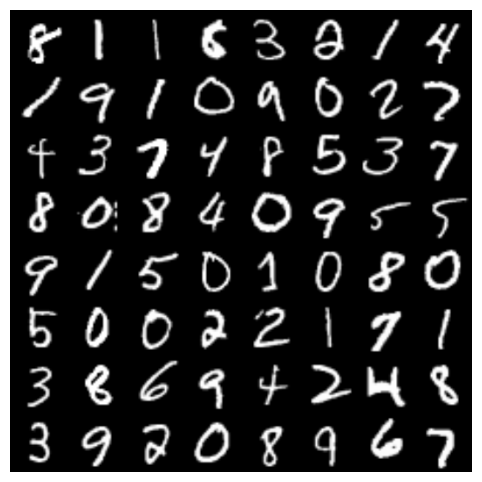

In [5]:
def plot_samples(samples, nrows=1, figsize=(8, 6)):
    samples = samples.detach().cpu()
    grid_img = torchvision.utils.make_grid(samples, nrow=nrows, value_range=(0, 1))
    fig = plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    return fig

num_samples = 64
samples = next(iter(train_loader))
images, labels = samples[0][:num_samples], samples[1][:num_samples]

print(images.shape)
print(labels.shape)
plot_samples(images, nrows=8)
plt.show()

## CVAE

#### CVAE model

In [6]:
class CVAE(BaseVAE):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        latent_dim = 128

        self.input_shape = input_shape
        self.num_classes = num_classes
        
        self.cls_embed = nn.Linear(num_classes, np.prod(input_shape[1:]))
        input_shape = (input_shape[0]+1, *input_shape[1:])

        self.encoder = Encoder(
            input_shape=input_shape,
            latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim + num_classes,
            output_shape=self.input_shape
        )
        self.kld_fn = KLDivDiagonalGaussian()

        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        var = torch.exp(log_var)
        eps = torch.randn_like(mu)
        z = mu + eps * var**0.5
        return z

    def forward(self, x, y):
        y = F.one_hot(y, num_classes=self.num_classes).to(torch.float)

        y_embed = self.cls_embed(y)
        y_embed = y_embed.reshape(-1, 1, *self.input_shape[1:])
        x = torch.cat([x, y_embed], dim=1)
        mu, log_var = self.encoder(x)

        z = self.reparameterize(mu, log_var)
        z = torch.cat([z, y], dim=1)
        x_hat = self.decoder(z)

        return (x_hat, z, mu, log_var)

    def loss_fn(self, x, x_hat, mu, log_var, kld_weight=1.0):
        recon = F.mse_loss(x_hat, x)
        kld = self.kld_fn(
            mu,
            torch.exp(log_var),
            torch.zeros(mu.shape[0], mu.shape[1]).to(mu.device),
            torch.ones(mu.shape[0], mu.shape[1]).to(mu.device)
        )
        kld = torch.mean(kld)
        loss = recon + kld_weight*kld
        return (loss, recon, kld)

    def sample_z(self, z, y):
        y = F.one_hot(y, num_classes=self.num_classes).to(torch.float)
        z = torch.cat([z, y], dim=1)
        return self.decoder(z)
    
    def sample(self, num_samples, device, labels=None):
        if labels is None:
            labels = torch.randint(0, self.num_classes, (num_samples,))
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels)
        y = labels
        y = y.to(device)
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)
        x_hat = self.sample_z(z, y)
        return (x_hat, z)

In [7]:
model = CVAE(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)
print(summary(
    model,
    input_size=[(batch_size, *input_shape), (batch_size,)], dtypes=[torch.float, torch.long]
))

c:\Users\xuanr\Desktop\Projects\vae\modules\vae_model.py:99: UserWarning: Mismatched dimension between reshape=(512, 2, 2) and latent_dim=138. A nn.Linear has been prepended to the model to give the desired reshape.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [64, 3, 64, 64]           --
├─Linear: 1-1                            [64, 4096]                45,056
├─Encoder: 1-2                           [64, 128]                 --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [64, 32, 32, 32]          1,248
│    │    └─Sequential: 3-2              [64, 64, 16, 16]          18,624
│    │    └─Sequential: 3-3              [64, 128, 8, 8]           74,112
│    │    └─Sequential: 3-4              [64, 256, 4, 4]           295,680
│    │    └─Sequential: 3-5              [64, 512, 2, 2]           1,181,184
│    └─Linear: 2-2                       [64, 128]                 262,272
│    └─Linear: 2-3                       [64, 128]                 262,272
├─Decoder: 1-3                           [64, 3, 64, 64]           --
│    └─Linear: 2-4                       [64, 20

#### Helper functions

In [8]:
def vis_samples(
    model,
    samples=None,
    labels=None,
    step=None,
    n_visualize=100,
    vis_embedd=True,
    batch_size=64,
    tag='val',
):
    if samples:
        samples = samples[:n_visualize]
        labels = labels[:n_visualize]
    else:
        n_per_cls = n_visualize // model.num_classes
        labels = []
        for i in range(model.num_classes):
            labels += [i]*n_per_cls
        labels = [0]*(n_visualize % model.num_classes) + labels
    
    x_hat_all = []
    z_all = []
    mu_all = []
    
    with torch.no_grad():
        for i in range(0, n_visualize, batch_size):
            y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)
            y = y.to(device)
            if samples:
                x = torch.stack(samples[i:i+batch_size], dim=0)
                x = x.to(device)
                x_hat, z, mu, log_var = model(x, y)
            else:
                n = min(batch_size, n_visualize-i)
                x_hat, z = model.sample(n, device=device, labels=y)
                _, _, mu, log_var = model(x_hat, y)
            x_hat_all += [x_hat.cpu()]
            z_all += [z.cpu()]
            mu_all += [mu.cpu()]
    
    x_hat_all = torch.cat(x_hat_all, dim=0)
    z_all = torch.cat(z_all, dim=0)
    mu_all = torch.cat(mu_all, dim=0)
    
    n_rows = int(np.ceil(np.sqrt(n_visualize)))
    
    if samples:
        mode = 'recon'
        x_all = torch.stack(samples, dim=0)
        fig_x = plot_samples(x_all, nrows=n_rows)
        tb_writer.add_figure(f'{tag}/{mode}/x', fig_x, step)
    else:
        mode = 'gen'

    fig_x_hat = plot_samples(x_hat_all, nrows=n_rows)
    tb_writer.add_figure(f'{tag}/{mode}/x_hat', fig_x_hat, step)
    
    if vis_embedd:
        tb_writer.add_embedding(
            z_all,
            metadata=labels,
            label_img=x_all if samples else x_hat_all,
            global_step=step,
            tag=f'{tag}/{mode}/z(x)'
        )
        tb_writer.add_embedding(
            mu_all,
            metadata=labels,
            label_img=x_all if samples else x_hat_all,
            global_step=step,
            tag=f'{tag}/{mode}/mu(x)'
        )

In [9]:
def evaluate(
    model,
    val_loader,
    step=None,
    n_visualize=100,
    tag='val',
):
    training = model.training
    model.eval()

    val_stat = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)
            x_hat, z, mu, log_var = model(x, y)
            loss, recon, kld = model.loss_fn(x, x_hat, mu, log_var, kld_weight=0)
            N = x.shape[0]
            val_stat += [[
                loss.item()*N, recon.item()*N, kld.item()*N
            ]]
    val_stat = np.array(val_stat)
    val_stat = np.sum(val_stat, axis=0)/len(val_loader.dataset)
    
    tb_writer.add_scalar(f'{tag}/loss', val_stat[0], step)
    tb_writer.add_scalar(f'{tag}/recon', val_stat[1], step)
    tb_writer.add_scalar(f'{tag}/kld', val_stat[2], step)

    if n_visualize:
        idx = np.random.choice(len(val_loader.dataset), n_visualize, replace=False)
        samples = [val_loader.dataset[i] for i in idx]
        vis_samples(
            model,
            [x[0] for x in samples],
            [x[1] for x in samples],
            step,
            n_visualize,
            tag=tag
        )
        vis_samples(model, None, None, step, n_visualize, tag=tag)
    
    model.train(training)
    return val_stat

In [10]:
def train(
    model,
    train_loader,
    optimizer,
    num_steps=20000,
    val_loader=None,
    checkpoint=1000,
    n_visualize=100,
):
    model.train()

    train_stats = []
    val_stats = []

    best_val_loss = np.inf
    train_iter = iter(train_loader)

    for step in tqdm(range(num_steps)):
        try:
            x, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            x, y = next(train_iter)
        x = x.to(device)
        y = y.to(device)

        x_hat, z, mu, log_var = model(x, y)
        loss, recon, kld = model.loss_fn(x, x_hat, mu, log_var, kld_weight=2e-4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            train_stats += [[
                step,
                loss.item(), recon.item(), kld.item()
            ]]
            val_stat = evaluate(model, val_loader, step, n_visualize, tag='val')
            val_stats += [[step, *val_stat]]

            if val_stat[0] < best_val_loss:
                best_val_loss = val_stat[0]
                torch.save(model.state_dict(), log_dir/'best_model.pth')
            
            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/loss/recon', recon.item(), step)
            tb_writer.add_scalar('train/loss/kld', kld.item(), step)
            
            if n_visualize:
                idx = np.random.choice(len(train_loader.dataset), n_visualize, replace=False)
                samples = [train_loader.dataset[i] for i in idx]
                vis_samples(
                    model,
                    [x[0] for x in samples],
                    [x[1] for x in samples],
                    step,
                    n_visualize,
                    tag='train'
                )
    
    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

#### Training

In [11]:
train_stats, val_stats = train(
    model,
    train_loader,
    torch.optim.Adam(model.parameters(), lr=1e-3),
    num_steps=20000,
    val_loader=val_loader,
    checkpoint=1000,
    n_visualize=100,
)
torch.save(model.state_dict(), log_dir/'model.pth')

100%|██████████| 20000/20000 [10:18<00:00, 32.31it/s]  


#### Learning curves

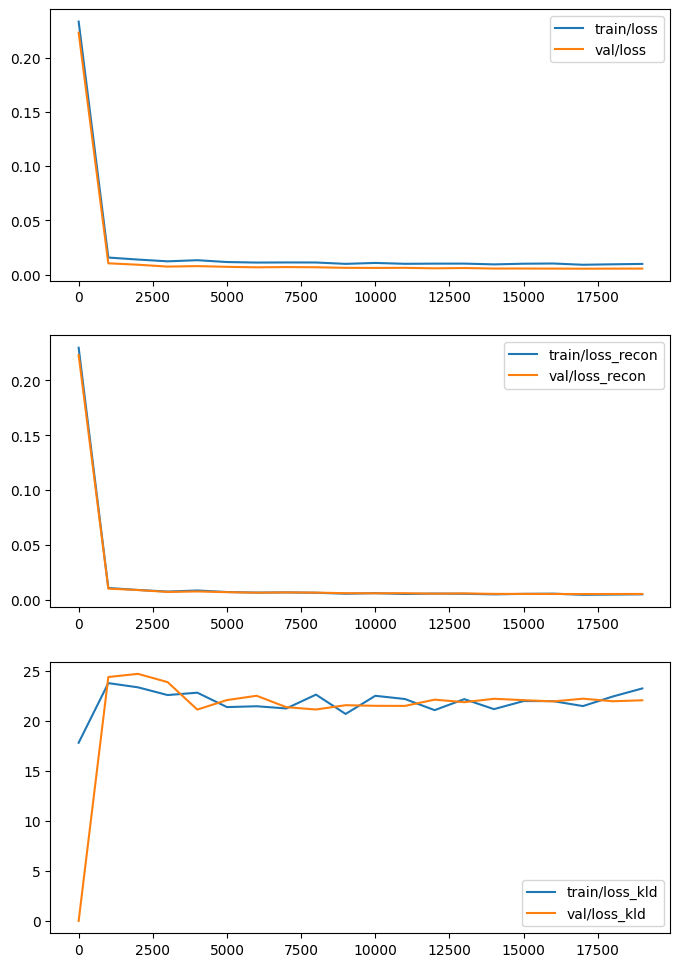

In [12]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train/loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='val/loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_stats[:, 0], train_stats[:, 2], label='train/loss_recon')
plt.plot(val_stats[:, 0], val_stats[:, 2], label='val/loss_recon')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_stats[:, 0], train_stats[:, 3], label='train/loss_kld')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='val/loss_kld')
plt.legend()
plt.show()

#### Evaluate the best model

##### Test losses

In [13]:
# model.load_state_dict(torch.load(log_dir/'best_model.pth'))
test_stat = evaluate(
    model,
    test_loader,
    n_visualize=100,
    tag='test'
)
print(test_stat)

[5.47670118e-03 5.47670118e-03 2.17772816e+01]


##### Visualize some generated samples

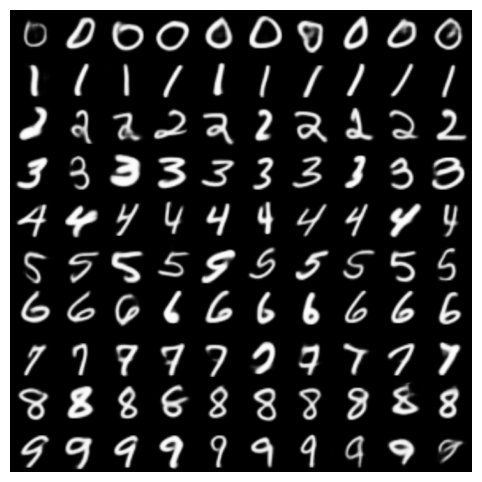

In [14]:
num_samples = 100
labels = [[i]*(num_samples//num_classes) for i in range(num_classes)]
labels = [[0]*(num_samples%num_classes)] + labels
labels = sum(labels, [])

samples = model.sample(num_samples, device=device, labels=labels)
plot_samples(samples[0], nrows=10)
plt.show()

##### Visualize embeddings

In [15]:
def vis_embeddings(
    model,
    samples=None,
    labels=None,
    step=None,
    n_visualize=100,
    batch_size=64,
    tag='val',
):
    if samples:
        samples = samples[:n_visualize]
        labels = labels[:n_visualize]
    else:
        n_per_cls = n_visualize // model.num_classes
        labels = []
        for i in range(model.num_classes):
            labels += [i]*n_per_cls
        labels = [0]*(n_visualize % model.num_classes) + labels

    x_hat_all = []
    z_all = []
    mu_all = []

    with torch.no_grad():
        for i in range(0, n_visualize, batch_size):
            y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)
            y = y.to(device)
            if samples:
                x = torch.stack(samples[i:i+batch_size], dim=0)
                x = x.to(device)
                x_hat, z, mu, log_var = model(x, y)
            else:
                n = min(batch_size, n_visualize-i)
                x_hat, z = model.sample(n, device=device, labels=y)
                _, _, mu, log_var = model(x_hat, y)
            x_hat_all += [x_hat.cpu()]
            z_all += [z.cpu()]
            mu_all += [mu.cpu()]
    
    x_hat_all = torch.cat(x_hat_all, dim=0)
    z_all = torch.cat(z_all, dim=0)
    mu_all = torch.cat(mu_all, dim=0)
    
    if samples:
        mode = 'recon'
        x_all = torch.stack(samples, dim=0)
    else:
        mode = 'gen'

    tb_writer.add_embedding(
        z_all,
        metadata=labels,
        label_img=x_all if samples else x_hat_all,
        global_step=step,
        tag=f'{tag}/{mode}/z(x)'
    )
    tb_writer.add_embedding(
        mu_all,
        metadata=labels,
        label_img=x_all if samples else x_hat_all,
        global_step=step,
        tag=f'{tag}/{mode}/mu(x)'
    )

In [16]:
n_visualize = 1000
idx = np.random.choice(len(test_loader.dataset), n_visualize, replace=False)

samples = [test_loader.dataset[i] for i in idx]
vis_embeddings(
    model,
    [x[0] for x in samples],
    [x[1] for x in samples],
    n_visualize=n_visualize,
    batch_size=batch_size,
    tag='test_embed'
)
vis_embeddings(
    model,
    None,
    None,
    n_visualize=n_visualize,
    batch_size=batch_size,
    tag='test_embed'
)